# Computing the Jacobian for heterogeneous-agent blocks

This notebook accompanies the working paper Auclert, Bardóczy, Rognlie, Straub (2019): "Using the Sequence-Space Jacobian to Solve and Estimate Heterogeneous-Agent Models". Please see the [Github repository](https://github.com/shade-econ/sequence-jacobian) for more information and code.

## 0 Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import hank

## 1 Getting the sequence-space Jacobian: fake news algorithm
In this notebook, we will use our one-asset HANK model as an example to work through the fake news algorithm that is implemented in our codebase. (Please see the `hank.ipynb` notebook for more details about this model.)

First, we calculate the steady state and load the household HetBlock ("heterogeneous agent block"), with the function determining transfers attached, from the `hank.py` module.

In [2]:
ss = hank.hank_ss()
household = hank.household_trans

### 1.1 Automatic implementation of fake-news method
Now, we can immediately get the Jacobian with respect to all aggregate inputs that might change: `w`, `r`, dividends `Div`, and lump-sum taxes `Tax`, by using the `jac` method of the `household` HetBlock.

In [3]:
T = 300
shock_list=['w', 'r', 'Div', 'Tax']
Js = household.jac(ss, T, shock_list)

`Js` is a nested dict, with keys on the first level being aggregate outputs:

In [4]:
Js.keys()

dict_keys(['N', 'C', 'A', 'NS'])

Note that we have Jacobians for four outputs: assets `A`, consumption `C`, labor `N`, and skill-weighted labor `NS` (which is the effective labor provided to firms).

We have these four outputs since we did not specify a list of outputs, and the default of the `jac` function is to calculate Jacobians for all outputs reported by the HetBlock (i.e. all outputs of the underlying function `hank.household()`).

For each output—for instance, assets `A`—we have Jacobians for all four inputs we asked about.

In [5]:
Js['A'].keys()

dict_keys(['w', 'r', 'Div', 'Tax'])

In total, this means that the code calculated 16 Jacobians, for each pair of 4 aggregate outputs and 4 aggregate inputs, each of which is 300-by-300, e.g.

In [6]:
Js['C']['r'].shape

(300, 300)

As usual, we can interpret column $s$ Jacobian of some output with respect to an input as giving the impulse response of the output to a "news shock" at date 0 that the input will change at date $s$.

Let's plot some columns $s=4,8,12,16,20$ of the Jacobian of $C$ vs. $r$, giving the impulse responses of consumption to news about the real interest rate at different dates.

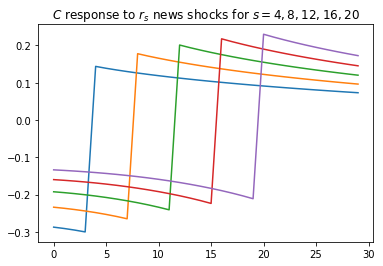

In [7]:
plt.plot(Js['C']['r'][:30, [4, 8, 12, 16, 20]])
plt.title('$C$ response to $r_s$ news shocks for $s=4,8,12,16,20$');

In response to a news shock $r_s$, consumption always jumps up between $s-1$ and $s$, consistent with the Euler equation ($r_s$ is defined to be the ex-post rate paid on savings between $s-1$ and $s$). But due to incomplete markets and borrowing constraints, the consumption response both before and after the shock ebbs.

### 1.2 Under the hood: the fake news algorithm
How did the `.jac()` method calculate all 16 300-by-300 Jacobians so quickly and automatically? Let's take a look inside the fake news algorithm. We'll go over `het.HetBlock.jac()` almost line-by-line, skipping only the saving and loading of saved data (which is not part of the algorithm), and providing additional detail in steps 3 and 4.

**Preliminary processing of steady state.** First, there are some preliminaries. (This part is more specific to our code and notation, although useful for understanding the algorithm that comes later.)

If the list of outputs is not provided, we ask the HetBlock what its outputs are (`non_back_outputs` means all outputs except the variable on which we're iterating backward, here the marginal value function):

In [8]:
output_list = household.non_back_outputs
output_list

{'a', 'c', 'n', 'ns'}

Then, we call a helper function to do some preliminary processing of the steady state `ss`, returning a number of outputs.

In [9]:
(ssin_dict, Pi, ssout_list, ss_for_hetinput, 
                         sspol_i, sspol_pi, sspol_space) = household.jac_prelim(ss)

These all relate to the steady-state backward and forward iterations. For instance, `ssin_dict` is exactly the dict of steady-state inputs needed for the backward iteration function. `ss_for_hetinput` is the dict of steady-state inputs needed for the `hetinput` function, which in this case takes in aggregate dividends and taxes and spits out skill-specific transfers.

In [10]:
ssin_dict.keys()

dict_keys(['e_grid', 'a_grid', 'frisch', 'r', 'beta', 'T', 'w', 'vphi', 'c_const', 'n_const', 'eis', 'ssflag', 'Pi_p', 'Va_p'])

In [11]:
ss_for_hetinput.keys()

dict_keys(['e_grid', 'div_rule', 'Tax', 'pi_e', 'Div', 'tax_rule'])

`Pi` is the Markov transition matrix for the exogenous state, here the 7 skill states `e` that scale labor income:

In [12]:
Pi.shape

(7, 7)

`sspol_i`, `sspol_pi`, and `sspol_space` all characterize the interpolated steady-state transition matrix across endogenous states (following Young 2010's method) for agents. (We represent it this way rather than as an explicit matrix to exploit the sparsity and save on space and time.)

In this case, the only endogenous state is the asset `a`, so this is the only key of each of the three dicts:

In [13]:
sspol_i.keys(), sspol_pi.keys(), sspol_space.keys()

(dict_keys(['a']), dict_keys(['a']), dict_keys(['a']))

The entries in `sspol_i['a']`, for instance, tell us the left asset grid coordinate of the two gridpoints to which the interpolated rule sends mass. This is an array of integers with the same dimensions as the state space.

In [14]:
sspol_i['a'].shape, sspol_i['a'].dtype

((7, 500), dtype('uint32'))

**Step 1 of fake news algorithm: backward iteration.** Now we can begin the actual fake news algorithm, as detailed on page 17 of the paper. The first step is, for each input shock for which we want the Jacobian, to do a backward iteration with $T$ steps (where $T$ is the truncation horizon) to get $\mathcal{Y}$ and $\mathcal{D}$.

To do so, we loop over inputs `i` in our `shock_list` (which we defined earlier as being `['w', 'r', 'Div', 'Tax']`) and run a backward iteration for each. We must supply information about the steady state, and then the `backward_iteration_fakenews` uses numerical differentiation (with some small difference $h$) to iterate the linearized system backward and get our $\mathcal{Y}$ and $\mathcal{D}$.

In [15]:
%%time
h = 1E-4
curlyYs, curlyDs = {}, {}
for i in shock_list:
    curlyYs[i], curlyDs[i] = household.backward_iteration_fakenews(i, output_list, ssin_dict,
                                    ssout_list, ss['D'], Pi.T.copy(), sspol_i, sspol_pi,
                                    sspol_space, T, h, ss_for_hetinput)

CPU times: user 704 ms, sys: 15.9 ms, total: 720 ms
Wall time: 721 ms


Each $\mathcal{Y}^{o,i}$ is a length-$T$ vector that characterizes the change in output $o$ given from news of a shock to input $i$ at each horizon $t$, holding the distribution fixed at the steady state. For instance, we can look at $\mathcal{Y}^{C,r}$.

In [16]:
len(curlyYs['r']['c'])

300

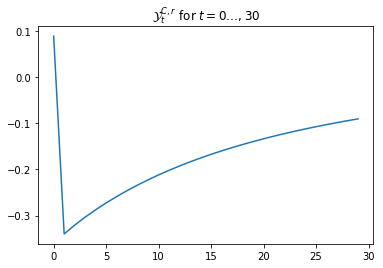

In [17]:
plt.plot(curlyYs['r']['c'][:30])
plt.title(r'$\mathcal{Y}^{C,r}_t$ for $t=0\ldots,30$');

This is fairly easy to interpret: if the shock to the ex-post real interest rate $r$ occurs *today*, at a horizon of 0, then we *increase* consumption, since we have more resources from the interest income and real interest rates going forward are unchanged.

But if the shock to $r$ is expected to arrive at a horizon greater than zero, we *decrease* consumption thanks to a substitution effect: we want to save more to earn the higher $r$ in the future. This effect is largest when the shock to $r$ is coming immediately in the future, at a horizon of 1, and shrinks as the shock to $r$ comes at more distant horizons.

By contrast, each $\mathcal{D}^i$ is an array with dimension of $T$ times the dimensions of the state space (here $7\times 500$, corresponding to 7 exogenous states and 500 asset gridpoints). For each $t$, this gives the first-order perturbation to the distribution of agents in the next period caused by the policy effect of the shock to input $i$ expected in $t$ periods.

For instance:

In [18]:
curlyDs['r'][0,...].shape

(7, 500)

is the first-order effect of an $r$ shock today on the distribution tomorrow.

Aggregating these $\mathcal{D}^r$ against the asset grid, we get the effect on tomorrow's aggregate assets, which also happens to be $\mathcal{Y}^{A,r}$. Let's plot these at all horizons from 0 to 30 and verify that they give the same answer:

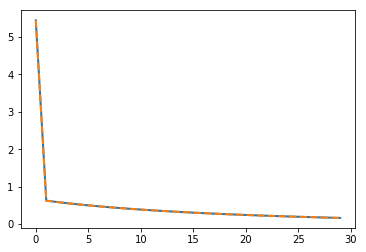

In [19]:
asset_effects = np.sum(curlyDs['r']*ss['a_grid'], axis=(1,2))
plt.plot(asset_effects[:30], linewidth=2)
plt.plot(curlyYs['r']['a'][:30], '--', linewidth=2);

Again, there is a distinction between a horizon of 0 and all other horizons: if the shock to $r$ occurs today, then the interest income means that we have lots more to save in assets, while if the shock to $r$ is occuring in the future, then there's just the substitution effect, which weakens with horizon.

Note that step 1 took about three-quarters of a second (on the laptop used to run this notebook). This is by far the costliest step of the fake news algorithm as currently implemented, since it involves a separate length-$T$ backward iteration for each shocked input.

**Step 2 of fake news algorithm: (transpose) forward iteration.** Now, we get the $\mathcal{P}^o_u$ for each output $o$ and $T-1$ values of $u$. To do so, we feed the steady-state values of each $o$ at each point on the grid, as well as variables characterizing the steady-state transition matrix over exogenous (`Pi`) and endogenous (`sspol_i` and `sspol_pi`) states, into the `forward_iteration_fakenews` function.

In [20]:
%%time
curlyPs = {}
for o in output_list:
    curlyPs[o] = household.forward_iteration_fakenews(ss[o], Pi, sspol_i, sspol_pi, T-1)

CPU times: user 54.8 ms, sys: 13.5 ms, total: 68.3 ms
Wall time: 69.6 ms


Note that this is much faster than the backward iteration. This is because the "transpose" forward iteration is just sparse linear algebra using the steady-state transition matrix; it can be implemented independent of the individual model, and we have done so efficiently.

Each $\mathcal{P}^o$ has dimension of $T-1$ times the dimension of the state space.

In [21]:
curlyPs['a'][1,...].shape

(7, 500)

$\mathcal{P}_u^o$ gives the effect that a perturbation to the distribution of agents will have on aggregate output $o$, $u$ periods later.

For example, $\mathcal{D}_0^r$, which we just discussed, gives the effect on the distribution at time 1 from a time-0 shock to the ex-post real interest rate $r$, is a certain perturbation to the distribution. Taking the vector dot product of this with $\mathcal{P}_u^A$ for $u=0,\ldots,29$, we can trace out the persistent effect of this shock on aggregate assets from time 1 to time 30. 

Let's plot this effect, and compare to the impulse response from a time-0 shock in the Jacobian we've already calculated to be sure we're correct:

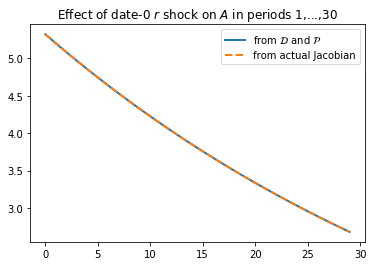

In [22]:
persistent_asset = np.array([np.vdot(curlyDs['r'][0,...],
                                     curlyPs['a'][u,...]) for u in range(30)])
plt.plot(persistent_asset, linewidth=2, label=r'from $\mathcal{D}$ and $\mathcal{P}$')
plt.plot(Js['A']['r'][1:31,0], '--', linewidth=2, label='from actual Jacobian')
plt.legend()
plt.title(f'Effect of date-0 $r$ shock on $A$ in periods 1,...,30');

**Step 3 of fake news algorithm: combine everything to make the fake news matrix for each output-input pair.** For each output-input pair $(o,i)$, step 3 is to build the "fake news matrix" $\mathcal{F}^{o,i}$, with $\mathcal{Y}^{o,i}$ in row $t=0$, and the product $(\mathcal{P}^o)(\mathcal{D}^i)'$ in rows $t=1,\ldots,T-1$. We can quickly do so:

In [23]:
%%time
Fs = {o.upper(): {} for o in output_list}
for o in output_list:
    for i in shock_list:
        F = np.empty((T,T))
        F[0, ...] = curlyYs[i][o]
        F[1:, ...] = curlyPs[o].reshape(T-1, -1) @ curlyDs[i].reshape(T, -1).T
        Fs[o.upper()][i] = F

CPU times: user 350 ms, sys: 6.81 ms, total: 357 ms
Wall time: 183 ms


Relative to the description in the paper, we take the transpose of $\mathcal{D}$, not of $\mathcal{P}$, since our convention in the code has the time dimension first (rather than last, as in the paper).

Also note the two `reshape` commands: these collapse the multiple dimensions corresponding to the state space into a single dimension (with length equal to the size of the state space), which matches the notation in the paper and allows us to multiply the two matrices along this dimension.

Note that this is the second costliest step of the algorithm, taking about a quarter of a second (on this laptop).

One way to think about what this step does is that there are $n_o\times n_i = 16$ fake news matrices, each with $T\times T = 90,000$ entries, so there are $16\times 90,000 = 1,440,000$ fake news matrix entries overall. For *each* of these entries except in the first row, we need to do a vector dot product of a $\mathcal{P}_t$ and a $\mathcal{D}_s$, each of which has dimensionality equal to the state space. In principle, this is quite computationally intensive! But since we structure it as one big matrix multiplication for each pair of $o$ and $i$, and matrix multiplication is a generic operation that is extremely efficiently implemented under the hood in many numerical packages, it's easy for this step to be fast.

Recall that each column $s$ of the ordinary Jacobian gives the impulse response to a news shock at date 0 about date $s$. Each column $s$ of the fake news matrix, by contrast, gives us the response to the corresponding "fake news" shock, where at date 1 the news is revealed to have been fake (and the shock does not actually happen).

To see the difference, compare the consumption impulse response to a true news shock about date-1 wages (which we'll get from the Jacobian we already calculated) to a fake news shock about date-1 wages.

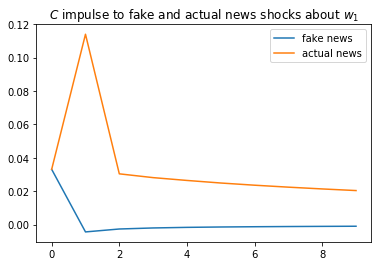

In [24]:
plt.plot(Fs['C']['w'][:10, 1], label='fake news')
plt.plot(Js['C']['w'][:10, 1], label='actual news')
plt.title(r'$C$ impulse to fake and actual news shocks about $w_1$')
plt.legend();

Consumption is the same in both cases in period 0, since at that point households have the same information about the "news" of higher wages at date 1. But then consumption spikes and stays elevated when the news of the wage shock is actually realized at date 1 ("actual"). In the fake news case, by contrast, no increase in wages is received, and consumption falls below its steady-state level as households rebuild their balance sheets after they dissaved at date 0 in response to the fake news.

Conceptually, the response to the actual news shock has two parts. First, there is the impulse from anticipation at date 0, which is the same for actual and fake news shocks. Then, there is the impulse to *actually getting* the wage increase at date 1. *This* impulse is the same as the impulse to an unanticipated shock at date 0 (shifted over to be at date 1).

This gives rise to a strategy for getting the second column of the Jacobian, the response to an actual news shock for date 1: add together the second column of the fake news matrix with the shifted first column of the Jacobian. Let's verify that this works.

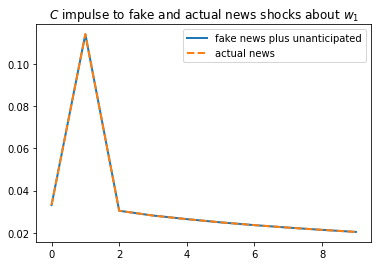

In [25]:
impulse = Fs['C']['w'][:10, 1].copy() # start with fake news impulse
impulse[1:10] += Js['C']['w'][:9, 0]   # add unanticipated impulse, shifted by 1

plt.plot(impulse, label='fake news plus unanticipated', linewidth=2)
plt.plot(Js['C']['w'][:10, 1], '--', label='actual news', linewidth=2)
plt.title(r'$C$ impulse to fake and actual news shocks about $w_1$')
plt.legend();

Success!

This insight, suitably generalized, is the basis of the recursion used in the final step to go from the fake news matrix to the Jacobian.

**Step 4 of fake news algorithm: recursively convert fake news matrices to actual Jacobian matrices.** Equation (30) in the paper shows that the following recursion relates the actual Jacobian $\mathcal{J}_{t,s}$ to the fake news matrix $\mathcal{F}_{t,s}$ (for any pair of outputs and inputs):

$$
\mathcal{J}_{t,s} =
\begin{cases}
\mathcal{F}_{t,s} & t=0\text{ or }s=0 \\
\mathcal{F}_{t,s} + \mathcal{J}_{t-1,s-1} & \text{otherwise}
\end{cases} \tag{30}
$$

Conceptually, this recursion builds on the idea that we discussed for step 3: representing actual impulses to news shocks as sums of fake news matrix entries and unanticipated shocks.

Let's implement this recursion to get our results. (Before we start, we'll save the Jacobian dict we already calculated to the name `Js_original` to avoid overwriting it along the way.)

In [26]:
%%time
Js_original = Js
Js = {o.upper(): {} for o in output_list}
for o in output_list:
    for i in shock_list:
        # implement recursion (30): start with J=F and accumulate terms along diagonal
        J = Fs[o.upper()][i].copy()
        for t in range(1, J.shape[1]):
            J[1:, t] += J[:-1, t-1]
        Js[o.upper()][i] = J

CPU times: user 29.1 ms, sys: 5.94 ms, total: 35.1 ms
Wall time: 33.6 ms


Success! Now we have the Jacobian.

This is the fastest and easiest of the steps. It reveals just how useful the fake news matrix is in obtaining the Jacobian.

Let's verify that the Jacobians in `Js` are *exactly* the same as that returned earlier by `.jac`, without even epsilon difference. This is only possible because we just followed the exact same steps as the `.jac` method.

In [27]:
for o in output_list:
    for i in shock_list:
        assert np.array_equal(Js[o.upper()][i], Js_original[o.upper()][i])

## 2 Not using the fake news algorithm? Costlier, direct approach
Suppose that we wanted to get the same Jacobians without using the fake news algorithm. The "direct" approach discussed in the paper (which could less charitably be called "brute force") uses numerical differentiation to do this.

The idea is to run `household.td`, which calculates the nonlinear household impulse response to a given shock, to a small version of each shock (multiplied by $h$) at each date $s$ from 0 up to $T$. We take the results, and rescaling by $h^{-1}$ we get each column $s$ of the Jacobian.

One crucial caveat is that since the numerically calculated steady state is not exactly a fixed point of backward or forward iteration, applying `household.td` without any shocks to the steady state does not return exactly the steady state. This numerical error can become quite significant in calculating the Jacobian when we blow it up by $h^{-1}$. We address this below in a simple way: first running `household.td` without any shocks, and then subtracting all the results by this to get the numerical derivative.

Below we differentiate with respect to only a single input, $r$, to avoid making the notebook run for too long.

In [28]:
%%time
T = 300
Js_direct = {}
short_shock_list = ('r')
h = 1E-4

Js_direct = {o.upper(): {i: np.empty((T, T)) for i in short_shock_list} for o in output_list}

# run td once without any shocks to get paths to subtract against
# (better than subtracting by ss since ss not exact)
# monotonic=True lets us know there is monotonicity of policy rule, makes TD run faster
# .td requires at least one input 'shock', so we put in steady-state w
td_noshock = household.td(ss, w=np.full(T, ss['w']), monotonic=True)

for i in short_shock_list:
    # simulate with respect to a shock at each date up to T
    for t in range(T):
        td_out = household.td(ss, **{i: ss[i]+h*(np.arange(T) == t)})
        
        # store results as column t of J[o][i] for each outcome o
        for o in output_list:
            Js_direct[o.upper()][i][:, t] = (td_out[o.upper()] - td_noshock[o.upper()])/h

CPU times: user 1min 5s, sys: 2.34 s, total: 1min 8s
Wall time: 1min 8s


We see that this took about 70 seconds. Since almost all the work is done separately for each shock, with all 4 input variables in `shock_list` this would take about 280 seconds.

Compare this to the time needed to get the Jacobian using our fake news algorithm, which is around one second:

In [29]:
%time _ = household.jac(ss, T, shock_list)

CPU times: user 1.15 s, sys: 42.7 ms, total: 1.19 s
Wall time: 974 ms


Hence, the extra time cost of the "direct" approach to getting the Jacobian, as we mention in the paper, is roughly a factor of $T=300$. Why? In the fake news algorithm, we did a single full backward iteration in step 1, whereas in the direct algorithm, we do $T$ full backward iterations. This dominates the running time and is primarily responsible for the factor-of-$T$ difference.

(Aside than this, the fake news algorithm has the extra steps 3 and 4, but makes up for it since its transpose forward iteration in step 2 is far, far faster than the $T$ nonlinear forward iterations in the direct approach.)

**Comparing results.**
Let's make sure that we have the same results from the fake news and direct algorithms by plotting some of the columns of the Jacobians. Let's look at the consumption response to real interest rate shocks.

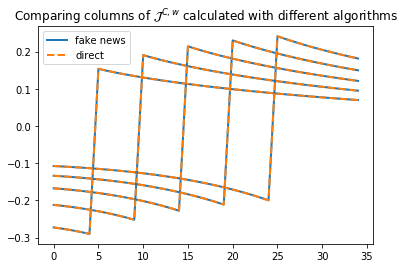

In [30]:
columns = (5, 10, 15, 20, 25)
l1, l2 = 'fake news', 'direct'
for col in columns:
    plt.plot(Js['C']['r'][:35, col], label=l1, linewidth=2, color='C0')
    plt.plot(Js_direct['C']['r'][:35, col], label=l2, linestyle='--', linewidth=2, color='C1')
    l1, l2 = '_nolegend_', '_nolegend_' # suppress extra legends
plt.title('Comparing columns of $\mathcal{J}^{C,w}$ calculated with different algorithms')
plt.legend()
plt.show()

A perfect match! This is one way to validate that the fake news algorithm gives the correct Jacobian.

Of course, the two do not give *numerically* identical results - although they are visually identical, and identical for practical purposes - since the underlying numerical differentiation is not infinitesimal and thus is affected by nonlinearities. It turns out that the fake news algorithm is more accurate than the direct algorithm in this regard, since it enforces linearity in the forward iteration and does a separate numerical differentiation at each step in the backward iteration, whereas the nonlinearities pile up in the direct algorithm.